In [76]:
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline

In [15]:
df = pd.read_csv('simpsons_raw.csv')

In [47]:
df['storyline_length'] = df.storyline.apply(lambda x: len(x.split(' ')))

In [53]:
def name_count(x, name):
    return x.lower().count(name.lower())

characters = ['Marge', 'Lisa', 'Homer', 'Bart', 'Maggie']

for character in characters:
    df[character] = df.storyline.apply(name_count, args=[character])

In [55]:
df['total_characters'] = df[characters].sum(axis = 1)

In [57]:
for character in characters:
    df[character + '_proportion'] = df[character]/df['total_characters']

In [66]:
means = df.groupby('season')[[character + '_proportion' for character in characters]].mean()

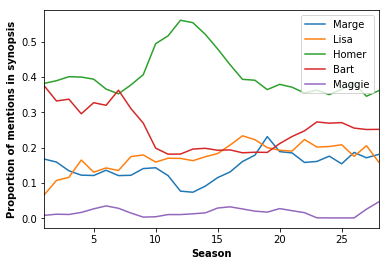

In [78]:
means.rolling(window=3, min_periods=1).mean().plot()
plt.legend(labels=characters)
plt.ylabel('Proportion of mentions in synopsis', weight = 'bold')
plt.xlabel('Season', weight = 'bold')

In [157]:
relationships = [('Lisa', 'Marge'),
('Lisa', 'Bart'),
('Homer', 'Marge'),
('Homer', 'Bart')]

In [158]:

rels = []

for season_range in [(1, 6), (7,9), (10, 16), (17, 26)]:
    rel_dict = {}
    corrs = df[(df['season'] >= season_range[0])&(df['season'] <= season_range[1])][characters].astype('bool').astype('int').corr()
    for rel in relationships:
        rel_dict['/'.join([rel[0], rel[1]])] = corrs[rel[0]][rel[1]]
    rels.append(rel_dict)

In [159]:
relationship_df = pd.DataFrame(rels, index = ['Early (1-6)', 'Peak (7-9)', 'Age of Homer (10-16)', 'Late (17+)'])

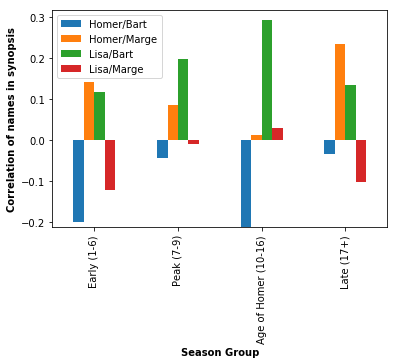

In [160]:
relationship_df.plot(kind='bar')
plt.ylabel('Correlation of names in synopsis', weight = 'bold')
plt.xlabel('Season Group', weight = 'bold')
plt.show()

In [389]:
import nltk
def extract_entities(text):
    if 'Written by' in text:
        text = text[:text.index('Written by')]
    names = []
    for sent in nltk.sent_tokenize(text):
        for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(sent))):
            if chunk.__class__ == nltk.tree.Tree and chunk.label() == 'PERSON':
                names.append(' '.join([i[0] for i in chunk.leaves()]))
    unique_names = list(set(names))
    best_names = []
    for i in range(len(unique_names)):
        name = unique_names[i]
        flag = 0
        for other_name in unique_names[:i] + unique_names[i+1:]:
            if name.lower() in other_name.lower():
                flag = 1
        if flag == 0:
            best_names.append(name)
    return '|'.join(best_names)

In [390]:
df.all_characters = df.storyline.apply(extract_entities)

In [391]:
from sklearn.feature_extraction.text import CountVectorizer



In [392]:
chocula = CountVectorizer(tokenizer = lambda x: x.split('|'),
                         stop_words = characters + [name + ' Simpson' for name in characters],
                         lowercase = False)

In [393]:
character_df = pd.DataFrame(chocula.fit_transform(df.all_characters).toarray(), columns = chocula.get_feature_names())

In [394]:
character_scores = character_df.sum(axis = 0)

In [395]:
scores = pd.DataFrame([character_df[name] * character_scores[name] for name in character_df.columns]).sum(axis = 0)
    

In [396]:
counts = character_df.sum(axis = 1)

In [397]:
character_commonness = pd.DataFrame([df.season, scores/counts]).transpose().groupby('season').mean()

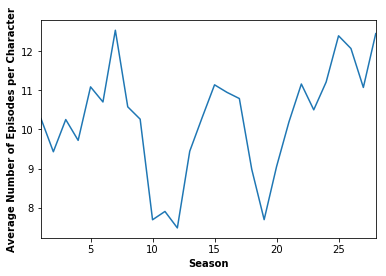

In [419]:
character_commonness.rolling(window=3, min_periods=1).mean().plot(legend=False)
plt.ylabel('Average Number of Episodes per Character', weight = 'bold')
plt.xlabel('Season', weight = 'bold')
plt.show()